In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import ssl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('../')
from fun.models import *
sns.set_style("whitegrid")
from torch.utils.data import random_split
from tqdm import tqdm
import pandas as pd
torch.manual_seed(42)
np.random.seed(42)

import random

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [4]:

transform = transforms.ToTensor()

dataset = torchvision.datasets.CIFAR10(
    root="../data",
    train=True,
    download=True,
    transform=transform  
)


torch.manual_seed(42)
valid_size = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size


train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
len(train_ds), len(valid_ds)

Files already downloaded and verified


(45000, 5000)

In [5]:
train_ds[0]

(tensor([[[0.2392, 0.2784, 0.3059,  ..., 0.3059, 0.2784, 0.2275],
          [0.4471, 0.4275, 0.3647,  ..., 0.3216, 0.2784, 0.2353],
          [0.3137, 0.2588, 0.1922,  ..., 0.3686, 0.3608, 0.3176],
          ...,
          [0.0157, 0.0235, 0.0000,  ..., 0.4431, 0.4078, 0.4431],
          [0.0314, 0.0549, 0.0235,  ..., 0.4627, 0.3804, 0.3529],
          [0.1490, 0.1490, 0.1137,  ..., 0.3765, 0.3294, 0.3569]],
 
         [[0.2235, 0.2431, 0.2745,  ..., 0.2549, 0.2275, 0.1843],
          [0.4275, 0.3922, 0.3412,  ..., 0.2863, 0.2392, 0.2000],
          [0.2980, 0.2353, 0.1922,  ..., 0.3451, 0.3255, 0.2824],
          ...,
          [0.0706, 0.0510, 0.0706,  ..., 0.2980, 0.2196, 0.1922],
          [0.0471, 0.0588, 0.0510,  ..., 0.3020, 0.2314, 0.1765],
          [0.1137, 0.0980, 0.0706,  ..., 0.2000, 0.1647, 0.1922]],
 
         [[0.2196, 0.2353, 0.2588,  ..., 0.2000, 0.1882, 0.1490],
          [0.4392, 0.4118, 0.3412,  ..., 0.2235, 0.1961, 0.1686],
          [0.2745, 0.2118, 0.1333,  ...,

In [6]:
# def augment_data(dataset, tr1, tr2, tr3):
#     dataset_augm = []
#     len_ds = len(dataset)
#     sample_to_aug1 = np.array(random.sample(range(len_ds), len_ds//5))
#     sample_to_aug2 = np.array(random.sample(range(len_ds), len_ds//5))
#     sample_to_aug3 = np.array(random.sample(range(len_ds), len_ds//5))

#     for index, img in enumerate(dataset):
#         img_tensor = img[0]
        
#         if index in sample_to_aug1:            
#             img_tensor = tr1(img_tensor)
#         if index in sample_to_aug2:            
#             img_tensor = tr2(img_tensor)
#         if index in sample_to_aug3:            
#             img_tensor = tr3(img_tensor)

#         dataset_augm.append((img_tensor, img[1]))
#     return dataset_augm


In [7]:
# torchvision_transform1 = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((34, 34)), 
#     transforms.RandomCrop(32),
#     transforms.ToTensor(),
# ])

# torchvision_transform2 = transforms.Compose([
#     transforms.ToPILImage(),   
#     transforms.Resize((28, 28)), 
#     transforms.Pad(padding=2), 
#     transforms.RandomHorizontalFlip(0.6),
#     transforms.ToTensor(),
# ])

# torchvision_transform3 = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ToTensor(),
# ])

In [8]:
# dataset_augm = augment_data(train_ds, torchvision_transform1,torchvision_transform2,torchvision_transform3)

In [9]:
# r = np.random.rand(1)
#         if args.beta > 0 and r < args.cutmix_prob:
#             # generate mixed sample
#             lam = np.random.beta(args.beta, args.beta)
#             rand_index = torch.randperm(input.size()[0]).cuda()
#             target_a = target
#             target_b = target[rand_index]
#             bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
#             input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
#             # adjust lambda to exactly match pixel ratio
#             lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
#             # compute output
#             output = model(input)
#             loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
#         else:
#             # compute output
#             output = model(input)
#             loss = criterion(output, target)

In [21]:
def rand_bbox(size, lam):
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(dataset, beta=1):
    if beta < 0:
        raise Exception("Beta must be greater than 0")

    dataset_augm = []
    # generate mixed sample
    
    for index, img in enumerate(dataset):
        img_tensor = img[0]
        rand_index = np.random.randint(0, len(dataset))
        # rand_index = torch.randperm(len(dataset)).cuda()
        img2 = dataset[rand_index]
        img2_tensor = img2[0]
        target_a = img[1]
        target_b = img2[1]

        lam = np.random.beta(beta, beta)
        bbx1, bby1, bbx2, bby2 = rand_bbox(img_tensor.size(), lam)

        img_tensor[0][bbx1:bbx2, bby1:bby2] = img2_tensor[0][bbx1:bbx2, bby1:bby2]
        img_tensor[1][bbx1:bbx2, bby1:bby2] = img2_tensor[1][bbx1:bbx2, bby1:bby2]
        img_tensor[2][bbx1:bbx2, bby1:bby2] = img2_tensor[2][bbx1:bbx2, bby1:bby2]
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img_tensor.size()[-1] * img_tensor.size()[-2]))

        dataset_augm.append((img_tensor, lam, target_a, 1-lam, target_b))
    return dataset_augm

In [22]:
dataset_augm = cutmix(train_ds)

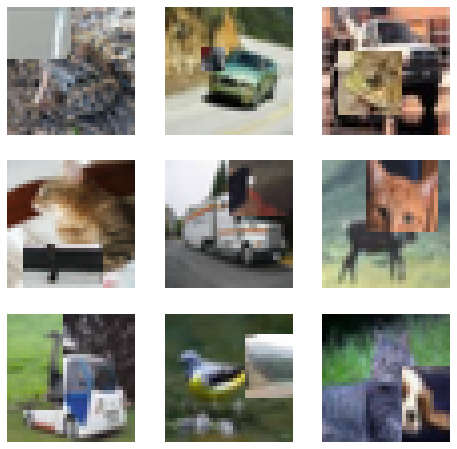

In [26]:

labels_map = {
    0:'plane', 
    1:'car', 
    2:'bird', 
    3:'cat',
    4:'deer', 
    5:'dog',
    6:'frog',
    7:'horse', 
    8:'ship', 
    9:'truck'

}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_augm), size=(1,)).item()
    img, _, _, _, _ = dataset_augm[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        
        pred = model(X)
        loss = loss_fn(pred, y)

       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    correct /= size
    print(f" Train Accuracy: {(100*correct):>0.1f}%, Train Avg loss {train_loss:>8f} \n")
    return correct, train_loss


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f} \n")
    return correct, test_loss
    

Using cuda device


In [ ]:
#------------------------------------------------------------------
#--------------------- DO PUSZCZENIA ------------------------------
#------------------------------------------------------------------
lr = 1e-3
batch_size = 8
epochs = 40


data = np.array([[0]*4]*epochs)
bnet_SGD_augm_history = pd.DataFrame(data, columns = ["test_acc", "train_acc", "test_loss", "train_loss"])

train_dataloader = DataLoader(
        dataset_augm,
        batch_size=batch_size, 
        shuffle=True
        )
test_dataloader = DataLoader(
    valid_ds, 
    batch_size=batch_size,
    shuffle=False
    )

net = Net_dropout_new(dropout_rate=0.25).to(device)
criterion = nn.CrossEntropyLoss()



optimizer = torch.optim.SGD(net.parameters(), lr=lr)

for t in range(epochs):

    print(f"Epoch {t+1}\n-------------------------------")
    train_acc, train_loss = train(train_dataloader, net, criterion, optimizer)
    test_acc, test_loss = test(test_dataloader, net, criterion)

    bnet_SGD_augm_history.loc[t,"train_acc"] = train_acc        
    bnet_SGD_augm_history.loc[t,"test_acc"] = test_acc
    bnet_SGD_augm_history.loc[t,"train_loss"] = train_loss
    bnet_SGD_augm_history.loc[t,"test_loss"] = test_loss
        

        

Epoch 1
-------------------------------
 Train Accuracy: 31.1%, Train Avg loss 1.872391 

Test Accuracy: 43.1%, Test Avg loss: 1.566988 

Epoch 2
-------------------------------
 Train Accuracy: 45.1%, Train Avg loss 1.512217 

Test Accuracy: 50.6%, Test Avg loss: 1.347959 

Epoch 3
-------------------------------
 Train Accuracy: 51.4%, Train Avg loss 1.343095 

Test Accuracy: 56.5%, Test Avg loss: 1.208601 

Epoch 4
-------------------------------
 Train Accuracy: 55.8%, Train Avg loss 1.234100 

Test Accuracy: 59.4%, Test Avg loss: 1.145690 

Epoch 5
-------------------------------
 Train Accuracy: 59.2%, Train Avg loss 1.150056 

Test Accuracy: 61.9%, Test Avg loss: 1.056537 

Epoch 6
-------------------------------
 Train Accuracy: 61.4%, Train Avg loss 1.093836 

Test Accuracy: 65.9%, Test Avg loss: 0.958288 

Epoch 7
-------------------------------
 Train Accuracy: 63.1%, Train Avg loss 1.046652 

Test Accuracy: 67.4%, Test Avg loss: 0.908093 

Epoch 8
--------------------------

In [ ]:
bnet_SGD_augm_history.to_csv(r"C:\Users\aleks\Desktop\DS\SEM_2\DL\Project1\DeepLearning\data\results\Net_dropout_new\sgd_augm_bs8_dr25\bnet_augm_history.csv")